In [1]:
%reset

In [2]:
data_dir='jena_climate_2009_2016.csv'
f=open(data_dir)
data=f.read()
f.close()
lines=data.split('\n')
header=lines[0].split(',')
lines=lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values


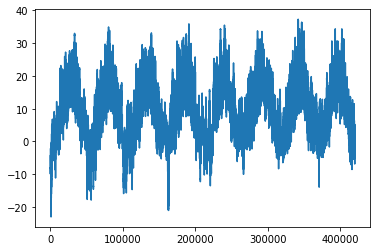

In [4]:
from matplotlib import pyplot as plt
temp = float_data[:, 1] # температура (в градусах Цельсия)
plt.plot(range(len(temp)), temp)


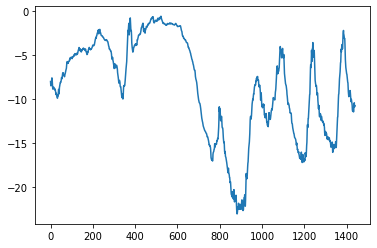

In [5]:
plt.plot(range(1440), temp[:1440])



In [6]:
lookback = 720
step = 6
delay = 144
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [7]:
import pandas as pd
pd.DataFrame(float_data).shape

(420451, 14)

In [8]:
def generator(data, lookback, delay, min_index, max_index,
shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),lookback // step,data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


In [9]:
lookback = 1440 #— количество наблюдений за предыдущие 5 дней;
step = 6#— шаг отбора образцов из наблюдений, то есть один образец за каждый
delay = 144#— целью являются следующие 24 часа в будущем
batch_size = 128
train_gen = generator(float_data, lookback=lookback, delay=delay,
                      min_index=0, max_index=200000, shuffle=True,
                      step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay,
                    min_index=200001, max_index=300000, step=step,
                    batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay,
                     min_index=300001, max_index=None, step=step,
                     batch_size=batch_size)
val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size


In [10]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
evaluate_naive_method()

0.2897359729905486


In [14]:
import pandas as pd
pd.DataFrame(float_data).head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.900147,-1.931358,-1.982110,-1.862800,1.072852,-1.307422,-1.473758,-0.798686,-1.476267,-1.478155,2.123751,-0.729505,-0.780680,-0.276136
1,0.906043,-1.975414,-2.025670,-1.915830,1.078831,-1.320427,-1.495196,-0.800752,-1.495025,-1.499321,2.171999,-0.931240,-0.887945,-0.463174
2,0.901327,-1.986710,-2.036839,-1.920016,1.108722,-1.323028,-1.497578,-0.802818,-1.498776,-1.501673,2.182354,-1.276143,-1.261228,-0.053306
3,0.898968,-1.964118,-2.013384,-1.886524,1.126657,-1.316525,-1.483286,-0.804884,-1.483770,-1.487562,2.157642,-1.178529,-1.317006,0.251497
4,0.898968,-1.959599,-2.010033,-1.882337,1.120678,-1.315225,-1.480904,-0.804884,-1.483770,-1.485211,2.153170,-1.191544,-1.261228,0.439690


In [11]:
float_data.shape[-1]

14

c:\users\karim\pycharmprojects\venv\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 11s 21ms/step - loss: 1.5010 - val_loss: 0.9826

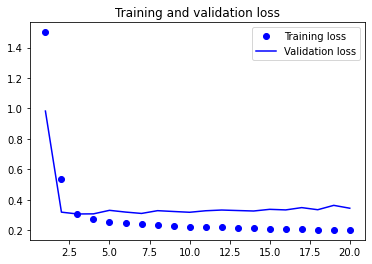

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
steps_per_epoch=500,
epochs=20,
validation_data=val_gen,
validation_steps=val_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Epoch 1/20
500/500 [==============================] - 63s 124ms/step - loss: 0.3019 - val_loss: 0.2699

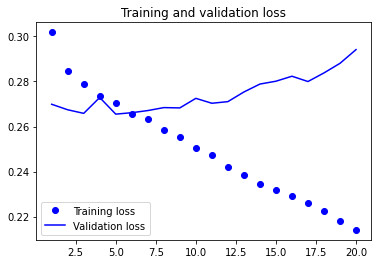

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
steps_per_epoch=500,
epochs=20,
validation_data=val_gen,
validation_steps=val_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()



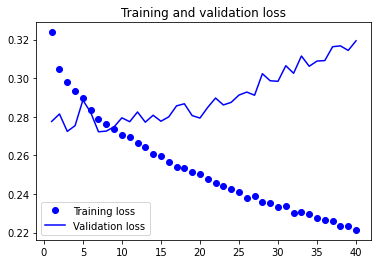

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(
    layers.GRU(
        32,
        dropout=0.2,
        recurrent_dropout=0.2,
        input_shape=(
            None, float_data.shape[-1]
                     )
    )
)
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(
    train_gen,
    steps_per_epoch=500,
    verbose=0,
    epochs=40,
    validation_data=val_gen,
    validation_steps=val_steps
)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

c:\users\karim\pycharmprojects\venv\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
500/500 - 206s - loss: 0.3197 - val_loss: 0.2814
Epoch 2/40
500/500 - 204s - loss: 0.3017 - val_loss: 0.2830
Epoch 3/40
500/500 - 210s - loss: 0.2941 - val_loss: 0.2721
Epoch 4/40
500/500 - 206s - loss: 0.2866 - val_loss: 0.2801
Epoch 5/40
500/500 - 208s - loss: 0.2807 - val_loss: 0.2742
Epoch 6/40
500/500 - 211s - loss: 0.2745 - val_loss: 0.2697
Epoch 7/40
500/500 - 210s - loss: 0.2697 - val_loss: 0.2854
Epoch 8/40
500/500 - 209s - loss: 0.2626 - val_loss: 0.2736
Epoch 9/40
500/500 - 210s - loss: 0.2604 - val_loss: 0.2839
Epoch 10/40
500/500 - 210s - loss: 0.2531 - val_loss: 0.2819
Epoch 11/40
500/500 - 216s - loss: 0.2496 - val_loss: 0.2843
Epoch 12/40
500/500 - 216s - loss: 0.2469 - val_loss: 0.2954
Epoch 13/40
500/500 - 216s - loss: 0.2426 - val_loss: 0.2940
Epoch 14/40
500/500 - 215s - loss: 0.2385 - val_loss: 0.2891
Epoch 15/40
500/500 - 215s - loss: 0.2351 - val_loss: 0.2946
Epoch 16/40
500/500 - 226s - loss: 0.2323 - val_loss: 0.3105
Epoch 17/40
500/500 - 220s - loss

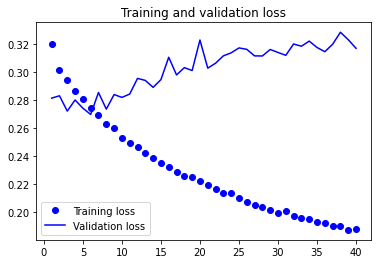

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(
    layers.GRU(
        32,
        dropout=0.1,
        recurrent_dropout=0.5,
        return_sequences=True,
        input_shape=(
            None, float_data.shape[-1]
                     )
    )
)
model.add(
    layers.GRU(
        64, activation='relu',
        dropout=0.1,
        recurrent_dropout=0.5
    )
) #При наложении друг на друга рекуррентных слоев
# в Keras все промежуточные слои должны возвращать
# полные выходные последовательности (трехмерный тензор),
# а не только последний интервал.
# Это достигается установкой параметра return_sequences=True.
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
steps_per_epoch=500,
epochs=40,
verbose=2,
validation_data=val_gen,
validation_steps=val_steps)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [17]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
max_features = 10000
maxlen = 500
(x_train, y_train), (x_test, y_test) = imdb.load_data( num_words=max_features)

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
x_train

array([[   0,    0,    0, ...,   22,   14,    1],
       [   0,    0,    0, ..., 1153,  194,    1],
       [   0,    0,    0, ...,   47,   14,    1],
       ...,
       [   0,    0,    0, ...,    6,   11,    1],
       [   0,    0,    0, ..., 7079, 1446,    1],
       [   0,    0,    0, ...,    6,   17,    1]])

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features,32))
model.add(
    layers.Bidirectional(
        layers.LSTM(32)
    )
)
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(
    x_train,
    y_train,
    epochs=10,
    verbose=2,
    batch_size=128,validation_split=0.2
                    )
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Dense(
    128,input_shape=(None, float_data.shape[-1])
    )
)
model.add(layers.Dense(
    64,
    )
)
model.add(layers.Bidirectional(
        layers.LSTM(
            64,dropout=0.1,
            recurrent_dropout=0.5,
        ),
        input_shape=(None, float_data.shape[-1])
        )
)
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(learning_rate=0.005), loss='mae')
history = model.fit_generator(train_gen,
steps_per_epoch=500,
epochs=40,
validation_data=val_gen,
verbose=2,
validation_steps=val_steps)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

c:\users\karim\pycharmprojects\venv\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
500/500 - 672s - loss: 0.3275 - val_loss: 0.3057
Epoch 2/40
500/500 - 648s - loss: 0.2840 - val_loss: 0.2934
Epoch 3/40
500/500 - 658s - loss: 0.2784 - val_loss: 0.2969
Epoch 4/40
500/500 - 632s - loss: 0.2736 - val_loss: 0.2954
Epoch 5/40
500/500 - 644s - loss: 0.2707 - val_loss: 0.2934
Epoch 6/40
500/500 - 672s - loss: 0.2676 - val_loss: 0.2942
Epoch 7/40
500/500 - 668s - loss: 0.2643 - val_loss: 0.2974
Epoch 8/40
500/500 - 679s - loss: 0.2654 - val_loss: 0.2988
Epoch 9/40
500/500 - 673s - loss: 0.2656 - val_loss: 0.2883
Epoch 10/40
500/500 - 679s - loss: 0.2633 - val_loss: 0.2890
Epoch 11/40
500/500 - 669s - loss: 0.2663 - val_loss: 0.3019
Epoch 12/40
500/500 - 640s - loss: 0.2640 - val_loss: 0.3089
Epoch 13/40
500/500 - 676s - loss: 0.2646 - val_loss: 0.3040
Epoch 14/40
500/500 - 641s - loss: 0.2655 - val_loss: 0.3144
Epoch 15/40
500/500 - 681s - loss: 0.2646 - val_loss: 0.3010
Epoch 16/40
500/500 - 645s - loss: 0.2664 - val_loss: 0.3021
Epoch 17/40
500/500 - 660s - loss

KeyboardInterrupt: 